In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional

In [28]:
import pandas as pd

# Loading our dataset
df = pd.read_csv('datasets/values.csv')
df['Date'] = pd.to_datetime(df['Date'])

stockList = df['Symbol'].unique()[:100]

df_ = {}
for symbol in stockList:
    df_[symbol] = df[df['Symbol'] == symbol].sort_values('Date').reset_index(drop=True)

print(df_['AAPL'].head())

  Symbol                       Date      Close  NormClose  DailyLogReturn  \
0   AAPL  2019-07-15 00:00:00-04:00  49.511902  -1.878514        0.467707   
1   AAPL  2019-07-16 00:00:00-04:00  49.340588  -1.882460       -0.173360   
2   AAPL  2019-07-17 00:00:00-04:00  49.063126  -1.888850       -0.282057   
3   AAPL  2019-07-18 00:00:00-04:00  49.620468  -1.876013        0.564969   
4   AAPL  2019-07-19 00:00:00-04:00  48.879761  -1.893074       -0.752247   

      ALR1W     ALR2W     ALR1M     ALR2M       RSI      MACD  
0  0.633085  0.634757  0.659704  0.708706  0.650353  0.846854  
1  0.397142  0.254992  0.705224  0.579130  0.631509  0.836484  
2  0.014587  0.053587  0.567239  0.568764  0.601130  0.796694  
3  0.474382  0.106986  0.424941  0.711992  0.638726  0.800901  
4 -0.086464 -0.141485  0.280707  0.852990  0.562803  0.735982  


In [29]:
df_new = {}

for symbol in stockList:
    df_new[symbol] = {}

    stock_df = df_[symbol].sort_values('Date').reset_index(drop=True)

    n_total = len(stock_df)
    n_train = int(0.8 * n_total)
    n_test = n_total - n_train

    df_new[symbol]['Train'] = stock_df.iloc[:n_train].reset_index(drop=True)
    df_new[symbol]['Test'] = stock_df.iloc[n_train:].reset_index(drop=True)

print(f"AAPL Train shape: {df_new['AAPL']['Train'].shape}")
print(f"AAPL Test shape: {df_new['AAPL']['Test'].shape}")
print(df_new['AAPL']['Train'].head())
print(df_new['AAPL']['Test'].head())


AAPL Train shape: (973, 11)
AAPL Test shape: (244, 11)
  Symbol                       Date      Close  NormClose  DailyLogReturn  \
0   AAPL  2019-07-15 00:00:00-04:00  49.511902  -1.878514        0.467707   
1   AAPL  2019-07-16 00:00:00-04:00  49.340588  -1.882460       -0.173360   
2   AAPL  2019-07-17 00:00:00-04:00  49.063126  -1.888850       -0.282057   
3   AAPL  2019-07-18 00:00:00-04:00  49.620468  -1.876013        0.564969   
4   AAPL  2019-07-19 00:00:00-04:00  48.879761  -1.893074       -0.752247   

      ALR1W     ALR2W     ALR1M     ALR2M       RSI      MACD  
0  0.633085  0.634757  0.659704  0.708706  0.650353  0.846854  
1  0.397142  0.254992  0.705224  0.579130  0.631509  0.836484  
2  0.014587  0.053587  0.567239  0.568764  0.601130  0.796694  
3  0.474382  0.106986  0.424941  0.711992  0.638726  0.800901  
4 -0.086464 -0.141485  0.280707  0.852990  0.562803  0.735982  
  Symbol                       Date       Close  NormClose  DailyLogReturn  \
0   AAPL  2023-05-24

In [30]:
for symbol in stockList:
    df_new[symbol]['Train'] = df_new[symbol]['Train'][['Date', 'Close']].copy()
    df_new[symbol]['Test'] = df_new[symbol]['Test'][['Date', 'Close']].copy()


In [31]:
df_new[symbol]["Train"]

,Date,Close
0,2019-07-15 00:00:00-04:00,60.477047
1,2019-07-16 00:00:00-04:00,59.574757
2,2019-07-17 00:00:00-04:00,59.221703
3,2019-07-18 00:00:00-04:00,58.719547
4,2019-07-19 00:00:00-04:00,58.837238
...,...,...
968,2023-05-17 00:00:00-04:00,102.076958
969,2023-05-18 00:00:00-04:00,103.002098
970,2023-05-19 00:00:00-04:00,103.479271
971,2023-05-22 00:00:00-04:00,102.223038


In [34]:
transform_train = {}
transform_test = {}
scaler = {}

for symbol in stockList:
    sc = MinMaxScaler(feature_range=(0, 1))

    train_close = np.array(df_new[symbol]["Train"]['Close']).reshape(-1, 1)
    test_close = np.array(df_new[symbol]["Test"]['Close']).reshape(-1, 1)

    transform_train[symbol] = sc.fit_transform(train_close)
    transform_test[symbol] = sc.transform(test_close)

    scaler[symbol] = sc

del train_close
del test_close


In [35]:
print("Train shapes:")
for symbol in transform_train:
    print(f"{symbol}: {transform_train[symbol].shape}")

print("\nTest shapes:")
for symbol in transform_test:
    print(f"{symbol}: {transform_test[symbol].shape}")


Train shapes:
AAPL: (973, 1)
ABBV: (973, 1)
ABT: (973, 1)
ACN: (973, 1)
ADBE: (973, 1)
AIG: (973, 1)
AMD: (973, 1)
AMGN: (973, 1)
AMT: (973, 1)
AMZN: (973, 1)
AVGO: (973, 1)
AXP: (973, 1)
BA: (973, 1)
BAC: (973, 1)
BK: (973, 1)
BKNG: (973, 1)
BLK: (973, 1)
BMY: (973, 1)
BRK-B: (973, 1)
C: (973, 1)
CAT: (973, 1)
CHTR: (973, 1)
CL: (973, 1)
CMCSA: (973, 1)
COF: (973, 1)
COP: (973, 1)
COST: (973, 1)
CRM: (973, 1)
CSCO: (973, 1)
CVS: (973, 1)
CVX: (973, 1)
DE: (973, 1)
DHR: (973, 1)
DIS: (973, 1)
DOW: (973, 1)
DUK: (973, 1)
EMR: (973, 1)
F: (973, 1)
FDX: (973, 1)
GD: (973, 1)
GE: (973, 1)
GILD: (973, 1)
GM: (973, 1)
GOOGL: (973, 1)
GS: (973, 1)
HD: (973, 1)
HON: (973, 1)
IBM: (973, 1)
INTC: (973, 1)
INTU: (973, 1)
JNJ: (973, 1)
JPM: (973, 1)
KHC: (973, 1)
KO: (973, 1)
LIN: (973, 1)
LLY: (973, 1)
LMT: (973, 1)
LOW: (973, 1)
MA: (973, 1)
MCD: (973, 1)
MDLZ: (973, 1)
MDT: (973, 1)
MET: (973, 1)
META: (973, 1)
MMM: (973, 1)
MO: (973, 1)
MRK: (973, 1)
MS: (973, 1)
MSFT: (973, 1)
NEE: (973, 1)
N

In [36]:
trainset = {}
testset = {}
window_size = 10

for symbol in stockList:
    trainset[symbol] = {}
    testset[symbol] = {}

    X_train, y_train = [], []
    X_test, y_test = [], []

    train_data = transform_train[symbol]
    for i in range(window_size, len(train_data)):
        X_train.append(train_data[i - window_size:i, 0])
        y_train.append(train_data[i, 0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    trainset[symbol]["X"] = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    trainset[symbol]["y"] = y_train

    test_data = transform_test[symbol]
    for i in range(window_size, len(test_data)):
        X_test.append(test_data[i - window_size:i, 0])
        y_test.append(test_data[i, 0])

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    testset[symbol]["X"] = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    testset[symbol]["y"] = y_test


In [38]:
arr_buff = []

for symbol in stockList:
    buff = {
        "X_train_shape": trainset[symbol]["X"].shape,
        "y_train_shape": trainset[symbol]["y"].shape,
        "X_test_shape": testset[symbol]["X"].shape,
        "y_test_shape": testset[symbol]["y"].shape
    }
    arr_buff.append(buff)

shape_summary_df = pd.DataFrame(arr_buff, index=stockList)
print(shape_summary_df)


     X_train_shape y_train_shape  X_test_shape y_test_shape
AAPL  (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
ABBV  (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
ABT   (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
ACN   (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
ADBE  (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
...            ...           ...           ...          ...
V     (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
VZ    (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
WFC   (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
WMT   (963, 10, 1)        (963,)  (234, 10, 1)       (234,)
XOM   (963, 10, 1)        (963,)  (234, 10, 1)       (234,)

[100 rows x 4 columns]


In [39]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    return x + res

In [40]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [41]:
time_steps = 10
input_shape=(time_steps,1)
model = build_model(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks = 1,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │     19,321 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 1)     │          0 │ dropout_8[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 1)     │          0 │ dropout_8[0][0],  │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │      2,816 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,396 (87.48 KB)

 Trainable params: 22,396 (87.48 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
for i in stockList:
    print("Fitting to", i)
    history = model.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=20, validation_split=0.2)

Fitting to AAPL
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.1356 - mean_squared_error: 0.1356 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss:

In [21]:
model.save_weights('transformer_model.weights.h5')

In [42]:
model = build_model(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks = 1,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

model.load_weights('transformer_model.weights.h5')


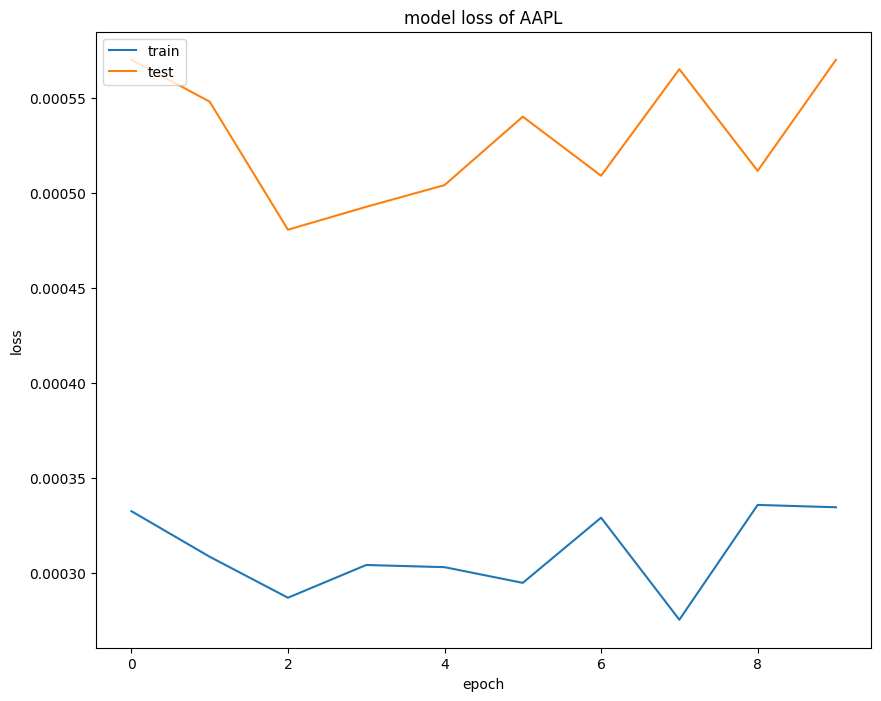

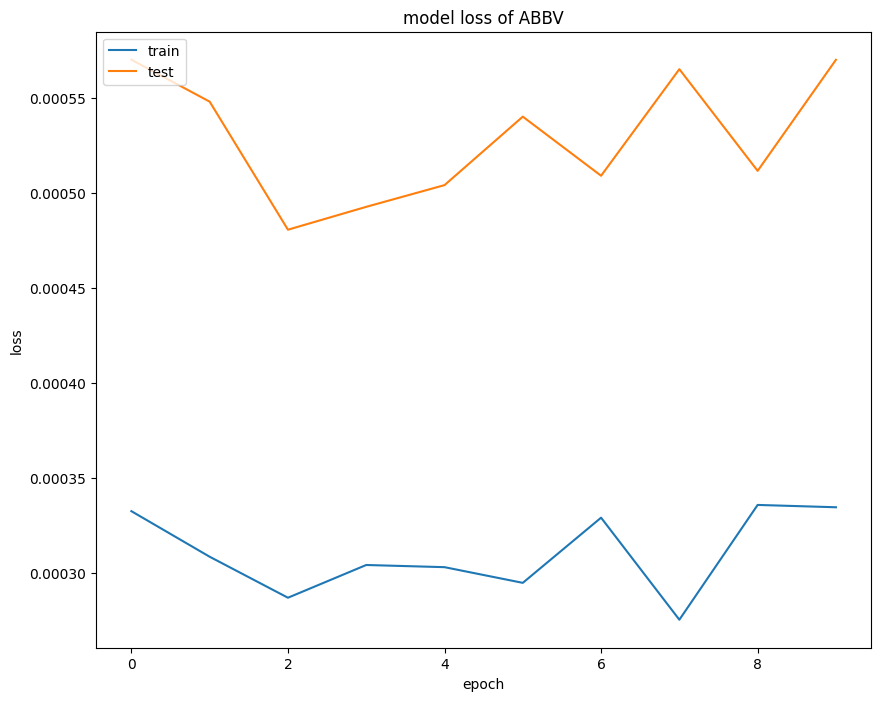

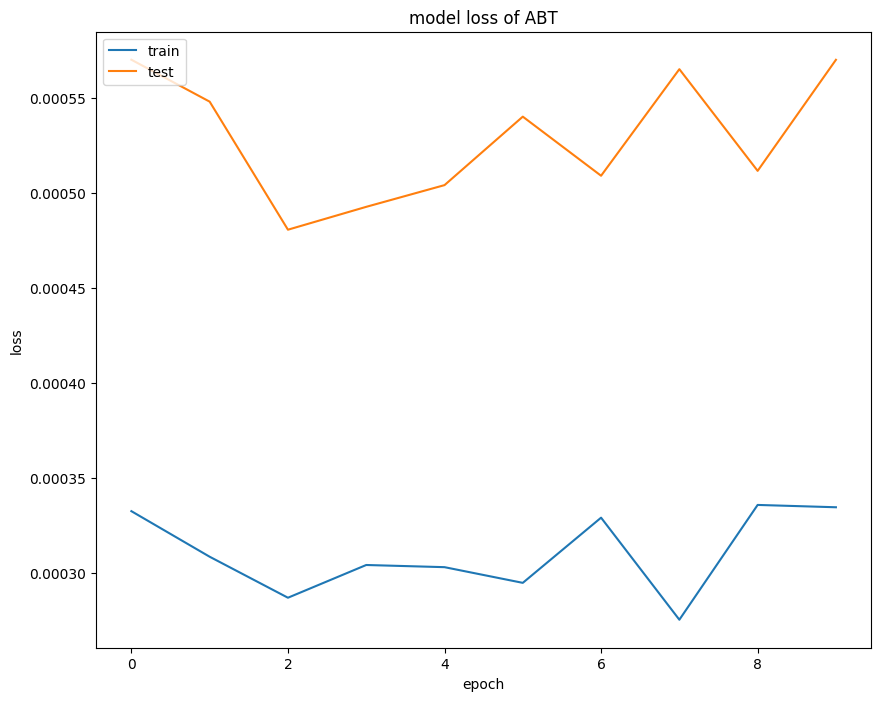

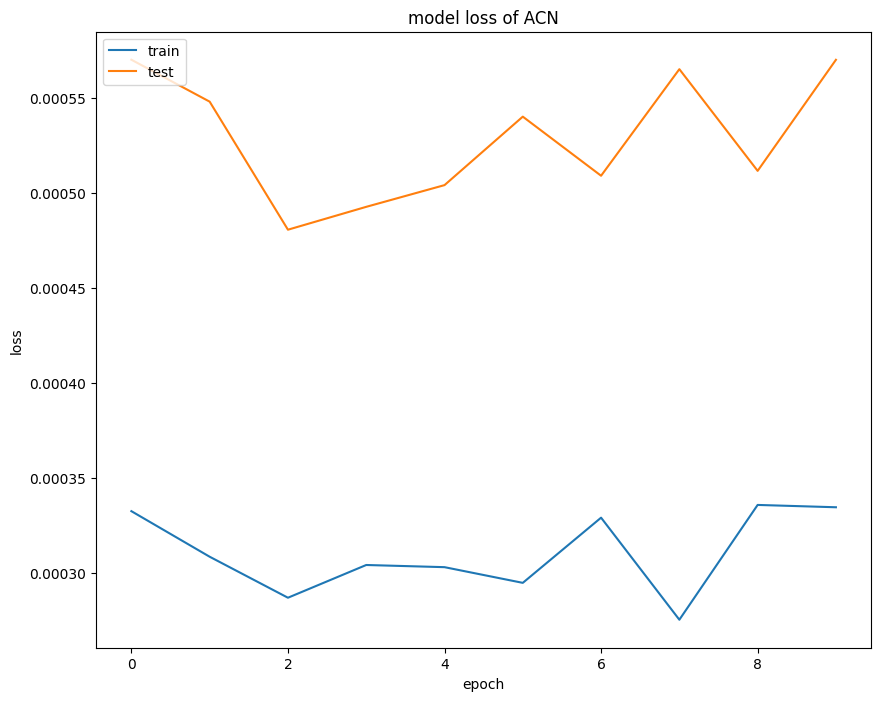

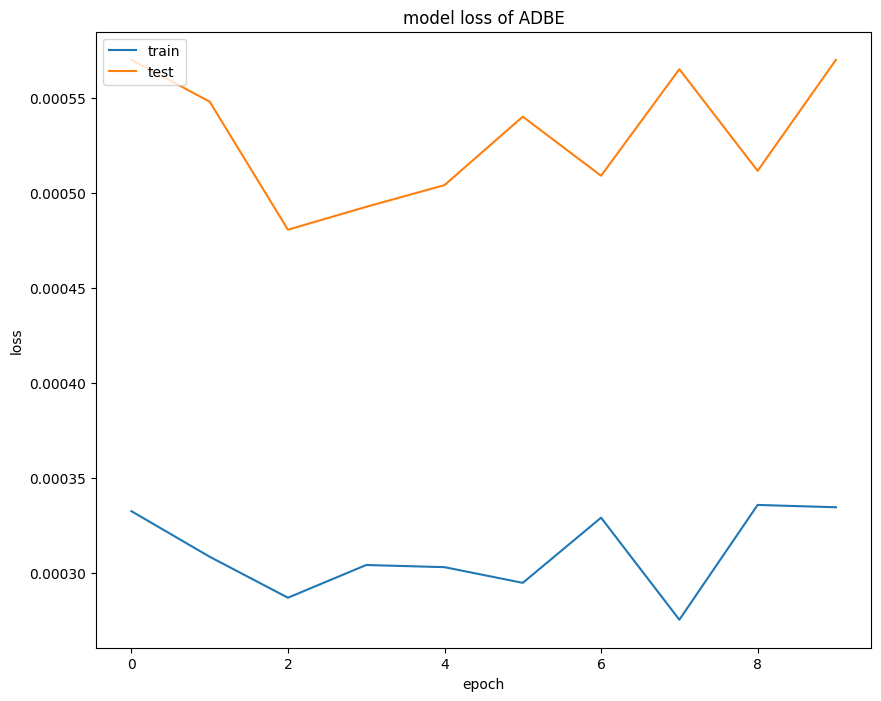

In [43]:
for i in stockList[0:5]:
  plt.rcParams['figure.figsize'] = (10,8)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss of ' + i)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


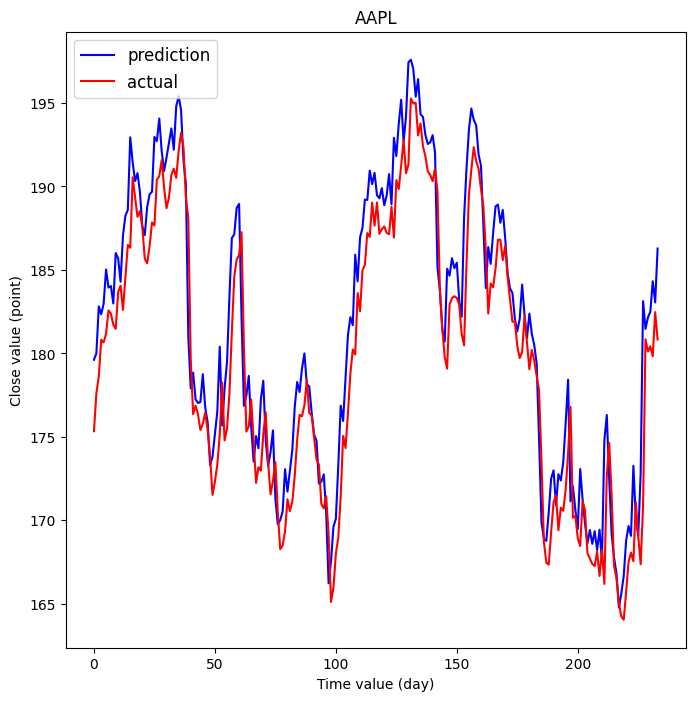

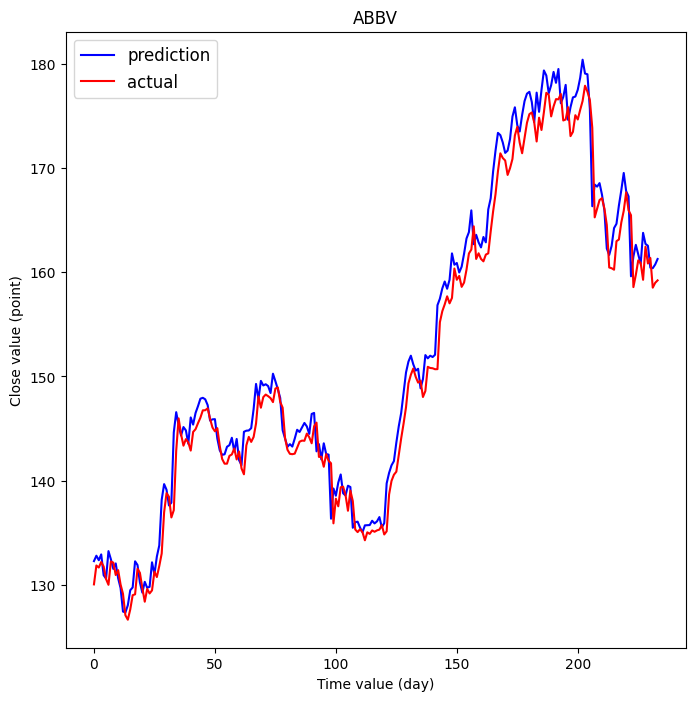

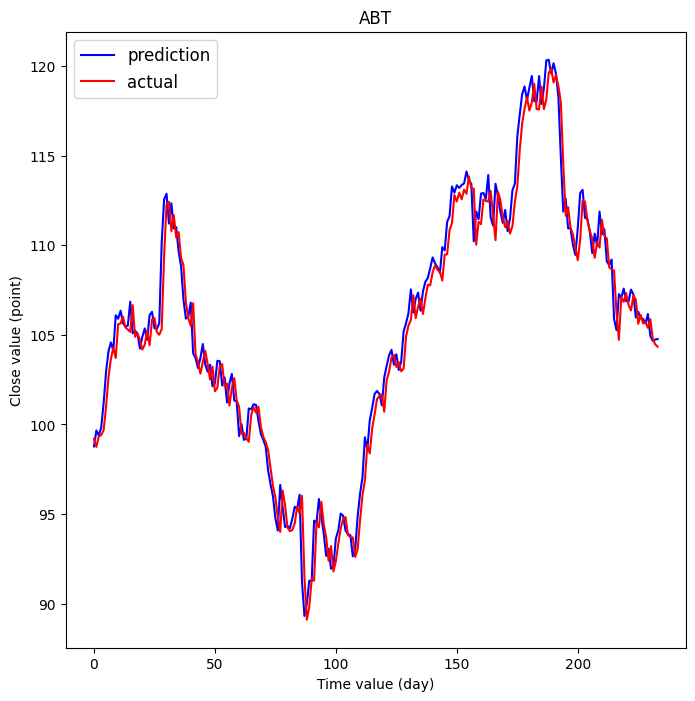

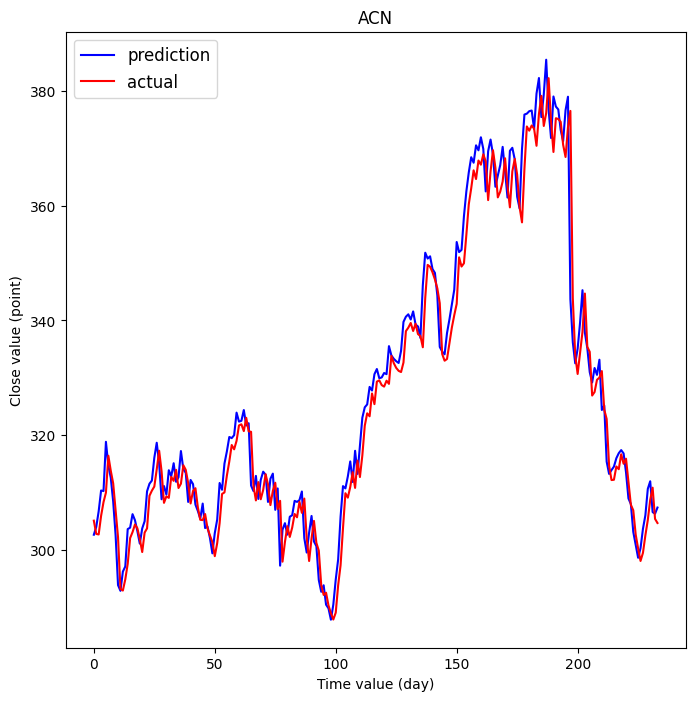

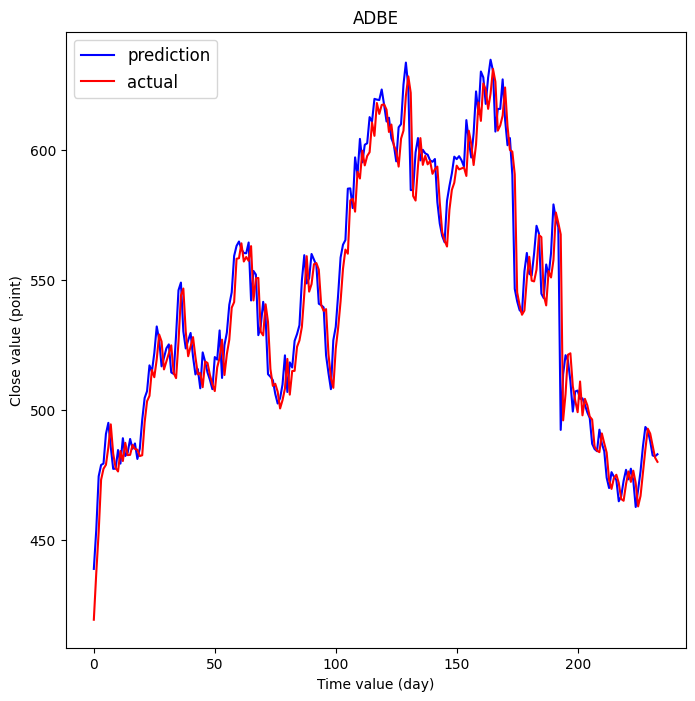

In [44]:
pred_result = {}
for i in stockList[0:5]:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(model.predict(testset[i]["X"]))
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    plt.figure(figsize=(8,8))
    plt.title("{}".format(i))
    plt.plot(y_true, color = 'b')
    plt.plot(y_pred, color = 'r')
    plt.xlabel("Time value (day)")
    plt.ylabel("Close value (point)")
    plt.legend(('prediction', 'actual'),loc='upper left', fontsize=12)

In [45]:
updown_result = {}

for symbol in stockList[0:5]:
    preds = pred_result[symbol]["Pred"].flatten()
    trues = pred_result[symbol]["True"].flatten()

    pred_trend = np.where(np.diff(preds) > 0, 1, 0)
    true_trend = np.where(np.diff(trues) > 0, 1, 0)

    updown_result[symbol] = {
        "Pred_Trend": pred_trend,
        "True_Trend": true_trend
    }


In [46]:
for symbol in stockList[0:5]:
    pred_trend = updown_result[symbol]["Pred_Trend"]
    true_trend = updown_result[symbol]["True_Trend"]

    min_len = min(len(pred_trend), len(true_trend))
    pred_trend = pred_trend[:min_len]
    true_trend = true_trend[:min_len]

    accuracy = (pred_trend == true_trend).mean()

    print(f"{symbol} Trend Prediction Accuracy: {accuracy*100:.2f}%")


AAPL Trend Prediction Accuracy: 49.79%
ABBV Trend Prediction Accuracy: 54.51%
ABT Trend Prediction Accuracy: 46.78%
ACN Trend Prediction Accuracy: 55.36%
ADBE Trend Prediction Accuracy: 51.07%
